In [294]:
import pandas as pd
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix, classification_report, hamming_loss, f1_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch

In [295]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [296]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/anna-
[nltk_data]     alexandradanchenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [297]:
RANDOM_SEED = 42

# Import Data

In [298]:
job_level_data = pd.read_csv("../data/JobLevelData_preproc.csv")
classes_labels = ['Chief Officer', 'Director', 'Individual Contributor/Staff', 'Manager',
 'Vice President']
job_level_data

,Title,Label
0,Vice President Director of Systems Engineering,"[0, 0, 0, 0, 1]"
1,Systems Engineer Systems Architect,"[0, 0, 1, 1, 0]"
2,Executive Director Global Informational Technology Infrastructure Chief Information Security Officer,"[1, 1, 0, 0, 0]"
3,Chief Technology Officer Executive Director of Technology Services,"[1, 1, 0, 0, 0]"
4,Vice President Chief Information Officer,"[0, 0, 0, 0, 1]"
...,...,...
2221,Net Software Architect and Team Project Lead,"[0, 0, 0, 1, 0]"
2222,Solutions Architect Technical Lead,"[0, 0, 1, 1, 0]"
2223,Manager Salesforcecom Administration and Release Engineering,"[0, 0, 0, 1, 0]"
2224,Innovation Automation Architect,"[0, 0, 0, 1, 0]"


To establish a baseline model for this multi label text classification task, it was chosen to transform the model to binary classification problem. This involves dividing the problem into 5 binary classification problems, one for each class.

In [299]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in word_tokens if word.lower() not in stop_words])
    return filtered_text

job_level_data["Title"] = job_level_data["Title"].apply(remove_stopwords)

In [300]:
job_level_data["Label"] = job_level_data["Label"].apply(eval)

In [301]:
X_train, X_test, y_train, y_test = train_test_split(
    job_level_data['Title'],
    pd.DataFrame(job_level_data['Label'].to_list(), columns=classes_labels),
    test_size=0.2,
    random_state=RANDOM_SEED,
    shuffle=True
)

In [302]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

X_train = pd.DataFrame(X_train.toarray(), columns=tfidf.get_feature_names_out())
X_test = pd.DataFrame(X_test.toarray(), columns=tfidf.get_feature_names_out())

In [303]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
clf = MultiOutputClassifier(rf)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

hamming = hamming_loss(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')

print(f'Hamming Loss: {hamming:.5f}')
print(f'F1 Score (micro): {f1:.5f}')

Hamming Loss: 0.04081
F1 Score (micro): 0.90267


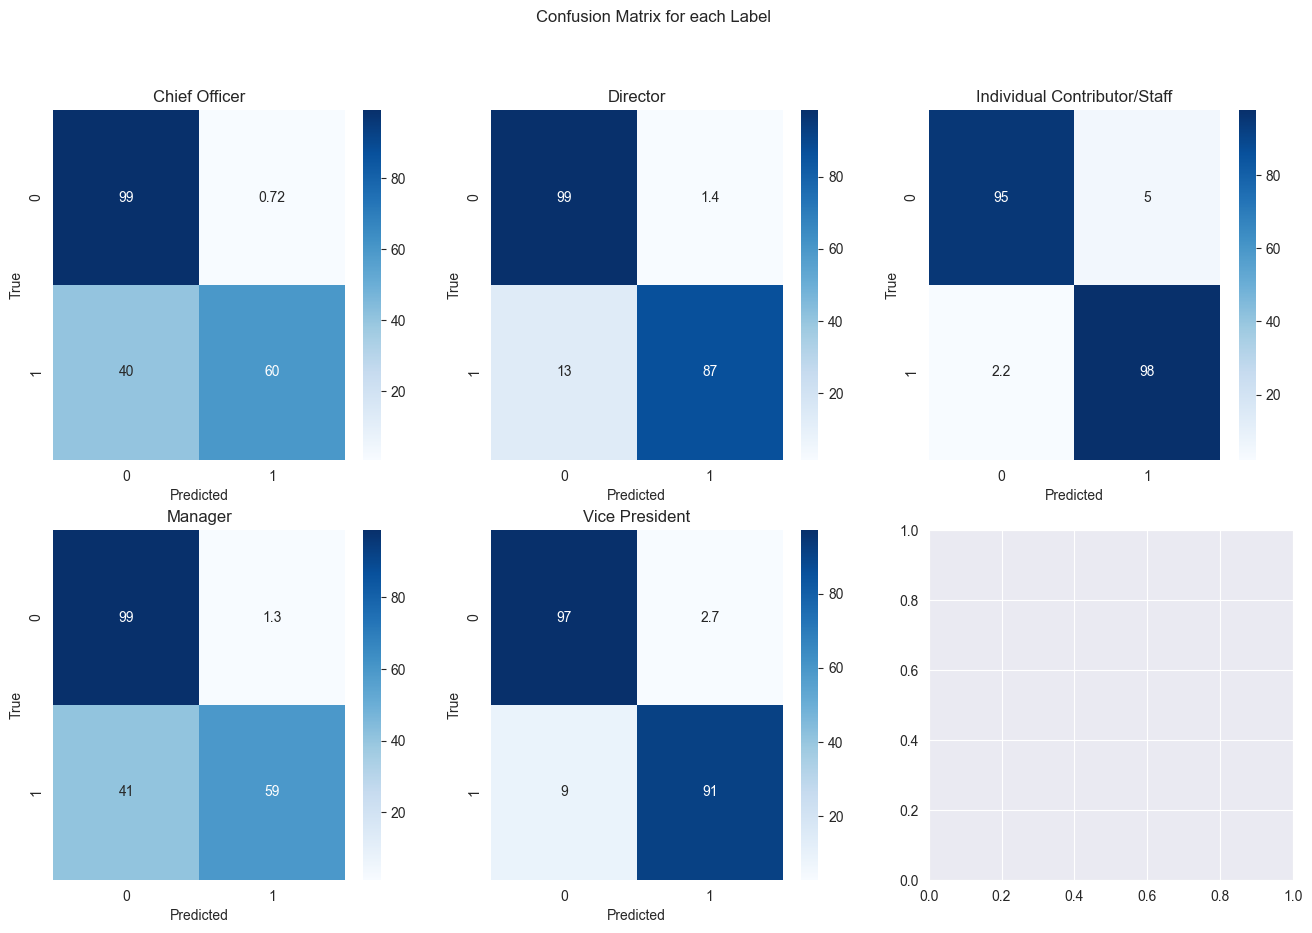

In [304]:
cm = multilabel_confusion_matrix(y_test.values.tolist(), y_pred.tolist())

f, axes = plt.subplots(2, 3, figsize=(16, 10))
f.suptitle("Confusion Matrix for each Label")

for i, matrix in enumerate(cm):
    with np.errstate(invalid='ignore'):
        normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] * 100
        normalized_matrix[np.isnan(normalized_matrix)] = 0 
    ax = axes[i//3, i % 3]
    sns.heatmap(normalized_matrix, annot=True, cmap='Blues', ax = ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(classes_labels[i])
""
plt.show()